# Check Salinity Budget

In [ ]:
from dask.distributed import Client

client = Client("tcp://10.32.5.126:35851")
client

In [1]:
import gcsfs
import xarray as xr
from matplotlib import pyplot as plt
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon


In [2]:
xr.set_options(display_style='text')

In [3]:
ds_original = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [4]:
gcs = gcsfs.GCSFileSystem()
ds = xr.open_zarr(gcs.get_mapper('/pangeo-tmp/rabernat/ECCOv4r3/salinity_budget.zarr'),
                  consolidated=True)
ds

<xarray.Dataset>
Dimensions:     (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g         (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1        (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u         (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables:
    G_adv       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_adv_conv  (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_diff      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_forc      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_tot       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>

In [5]:
ds.G_adv.data

dask.array<zarr, shape=(288, 50, 13, 90, 90), dtype=float32, chunksize=(48, 50, 1, 90, 90), chunktype=numpy.ndarray>

In [6]:
rhs = ds.G_adv + ds.G_adv_conv + ds.G_diff + ds.G_forc

In [7]:
selector = dict(time=200, face=8, i=45, j=45)
ds_point = ds.isel(**selector).load()
rhs_point = rhs.isel(**selector).load()

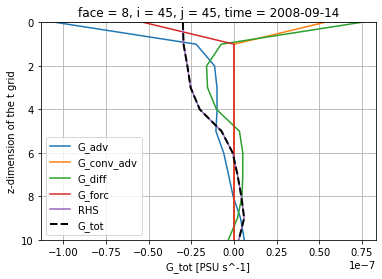

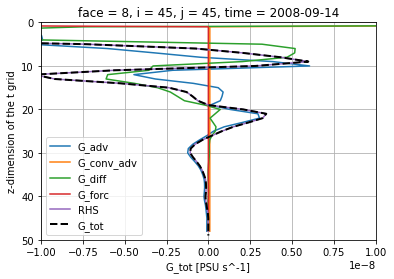

In [8]:
for xlim in [None, 1e-8]:
    plt.figure()
    ds_point.G_adv.plot(y='k', label='G_adv')
    ds_point.G_adv_conv.plot(y='k', label='G_conv_adv')
    ds_point.G_diff.plot(y='k', label='G_diff')
    ds_point.G_forc.plot(y='k', label='G_forc')
    rhs_point.plot(y='k', label='RHS')   
    ds_point.G_tot.plot(y='k', label='G_tot', color='k', ls='--', linewidth=2)   
    if xlim:
        plt.xlim([-xlim, xlim])
        plt.ylim([50, 0])
    else:
        plt.ylim([10, 0])

    plt.grid()
    plt.legend()

## Merge ryan's ds w original ecco ds to be able to use `faces_dataset_to_latlon`

In [9]:
ds_merged = xr.merge([ds, ds_original])

In [10]:
ds_merged

<xarray.Dataset>
Dimensions:     (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g         (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1        (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u         (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
    Depth       (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC      (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF      (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC          (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG          (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC          (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG          (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z           (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl          (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1         (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu          (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drC         (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drF         (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC         (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG         (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyC         (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyG         (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    hFacC       (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacS       (k, face, j_g, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacW       (k, face, j, i_g) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    iter        (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    iter_snp    (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    rA          (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs         (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw         (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
Data variables:
    G_adv       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_adv_conv  (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_diff      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_forc      (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    G_tot       (time, k, face, j, i) float32 dask.array<chunksize=(48, 50, 1, 90, 90), meta=np.ndarray>
    ADVr_SLT    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH     (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT    (time, k, f

In [11]:
ds_ll = faces_dataset_to_latlon(ds_merged)

In [13]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [14]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)
ds_slt = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)#(i=100, i_g=100)
ds_slt

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:     (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * k_l         (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u         (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1        (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    G_adv       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_adv_conv  (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_diff      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_forc      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    G_tot       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 90, 90), meta=np.ndarray>
    ADVr_SLT    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH     (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH     (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH     (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ETAN        (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    ETAN_snp    (time_snp, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    GEOFLX      (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    MXLDEPTH    (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SALT        (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SALT_snp    (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SFLUX       (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    TFLUX       (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    THETA       (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    THETA_snp   (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    WVELMASS    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    WVELSTAR    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    oceFWflx    (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceQsw      (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceSPtnd    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVx_SLT    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_SLT    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    ADVx_TH     (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_TH     (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_SLT    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_SLT    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_TH     (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_TH     (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    UVELMASS    (time, k, j, i_g) float32 d

In [33]:
ds_slt.i

<xarray.DataArray 'i' (i: 360)>
array([  0,   1,   2, ..., 357, 358, 359])
Dimensions without coordinates: i

In [24]:
ds_slt.G_adv.j

<xarray.DataArray 'j' (j: 270)>
array([  0,   1,   2, ..., 267, 268, 269])
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
Attributes:
    axis:           Y
    long_name:      y-dimension of the t grid
    standard_name:  y_grid_index
    swap_dim:       YC

In [15]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [16]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [17]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [18]:
volume = (coords.drF * coords.rA * coords.hFacC).isel(**lat_range_noface, **lon_range_noface)

In [19]:
ds_wg = ds_slt.isel(**lat_range, **lon_range)

In [21]:
ds_wg.ADVr_SLT.i

<xarray.DataArray 'i' (i: 95)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94])
Dimensions without coordinates: i

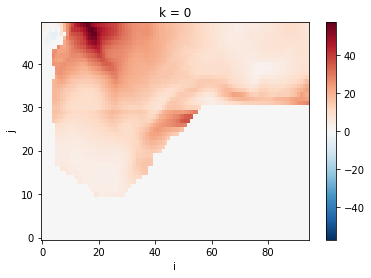

In [23]:
(ds_wg.G_tot * volume).mean(dim='time')[0].plot()

In [ ]:
ds_wg.G_

In [24]:
ds_slt_new = xr.Dataset({'G_adv':ds_wg.G_adv,
                         'G_adv_conv':ds_wg.G_adv_conv,
                         'G_diff':ds_wg.G_diff,
                         'G_forc':ds_wg.G_forc,
                         'G_tot':ds_wg.G_tot})

In [25]:
ds_slt_new = ds_slt_new * volume

## checking if new wg ds is right

In [26]:
rhs = ds_slt_new.G_adv + ds_slt_new.G_adv_conv + ds_slt_new.G_diff + ds_slt_new.G_forc

In [27]:
selector = dict(time=200, i=45, j=45)
ds_point = ds_slt_new.isel(**selector).load()
rhs_point = rhs.isel(**selector).load()

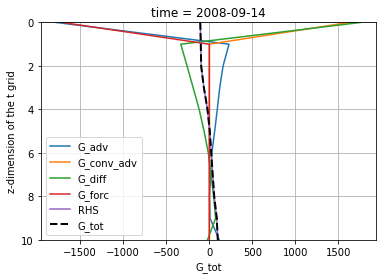

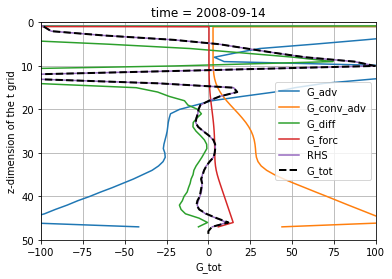

In [28]:
for xlim in [None, 1e2]:
    plt.figure()
    ds_point.G_adv.plot(y='k', label='G_adv')
    ds_point.G_adv_conv.plot(y='k', label='G_conv_adv')
    ds_point.G_diff.plot(y='k', label='G_diff')
    ds_point.G_forc.plot(y='k', label='G_forc')
    rhs_point.plot(y='k', label='RHS')   
    ds_point.G_tot.plot(y='k', label='G_tot', color='k', ls='--', linewidth=2)   
    if xlim:
        plt.xlim([-xlim, xlim])
        plt.ylim([50, 0])
    else:
        plt.ylim([10, 0])

    plt.grid()
    plt.legend()

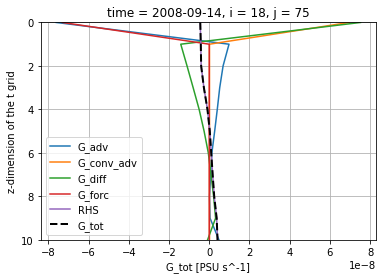

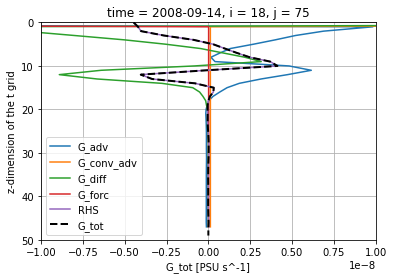

In [21]:
for xlim in [None, 1e-8]:
    plt.figure()
    ds_point.G_adv.plot(y='k', label='G_adv')
    ds_point.G_adv_conv.plot(y='k', label='G_conv_adv')
    ds_point.G_diff.plot(y='k', label='G_diff')
    ds_point.G_forc.plot(y='k', label='G_forc')
    rhs_point.plot(y='k', label='RHS')   
    ds_point.G_tot.plot(y='k', label='G_tot', color='k', ls='--', linewidth=2)   
    if xlim:
        plt.xlim([-xlim, xlim])
        plt.ylim([50, 0])
    else:
        plt.ylim([10, 0])

    plt.grid()
    plt.legend()

In [29]:
import json
with open('/home/jovyan/WMT/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [30]:
ds_slt_new

<xarray.Dataset>
Dimensions:     (i: 95, j: 50, k: 50, time: 288)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: i, j
Data variables:
    G_adv       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_adv_conv  (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_diff      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_forc      (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_tot       (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>

In [34]:
ds_slt_new.i

<xarray.DataArray 'i' (i: 95)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94])
Dimensions without coordinates: i

In [31]:
#saving ryan's salinity budget ds
gcsmap_slt_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg_new.zarr')
ds_slt_new.to_zarr(gcsmap_slt_wg, mode='w')